<a href="https://colab.research.google.com/github/Kwonjihan/ML-teamproject/blob/developtemp/SeongYeomByeon/BERT_pretraining_with_cosine_sim_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[상위 레이어의 Attention에 Embedding 유사도를 반영]**
- "How Does BERT Answer Questions? A Layer-Wise Analysis of Transformer Representations" 논문에 제시된 [Phases of BERT’s Transformations] 파트를 보면, BERT기반 모델의 초기 레이어는 토큰들을 주제별 클러스터로 그룹화하는 역할을 수행할 뿐, 의미 탐색 작업에 대해서는 낮은 정확도를 기록함.
- 하위 레이어에 대한 임베딩 유사도 반영은, 아직 의미적 요소조차 학습하지 못한 상태의 attention에 학습을 저하시키는 방향으로 작용할 것.
- 이에 반해 상위 레이어는 직접적인 토큰들 사이의 문맥적 맥락을 이해하는 역할을 수행하므로, 해당 attention score에 임베딩 벡터들간의 유사도를 반영한다면, 학습을 가속화하는 요소로 작용할 수 있지 않을까?
- 상위 레이어(레이어 수 / 2번째 이상 레이어)의 attention score를 계산할 때, Query와 Key의 Cosine similarity 행렬을 구함 -> 해당 행렬을 attention score에 합산

> 인용구 추가



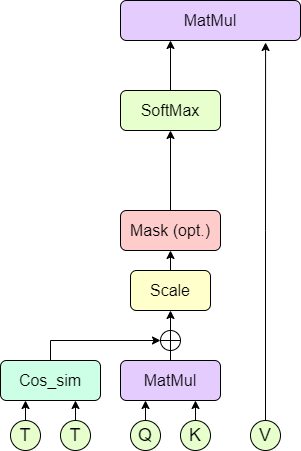

참고문헌 : https://ar5iv.labs.arxiv.org/html/1909.04925

In [1]:
!pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.7 MB/s eta 0:00:00


In [2]:
import math
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.optim import AdamW
import random
import torch.optim as optim
from torch.utils.data import RandomSampler, DataLoader, random_split
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, DataCollatorForLanguageModeling
from typing import Optional, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers.modeling_outputs import ModelOutput, MaskedLMOutput

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# activation function 불러오기
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

ACT2FN = {"gelu": gelu, "relu": torch.nn.functional.relu, "swish": torch.nn.functional.silu}

In [5]:
class Config:
    vocab_size=30522
    hidden_size=768
    num_hidden_layers=8
    num_attention_heads=12
    intermediate_size=3072
    hidden_act="gelu"
    hidden_dropout_prob=0.1
    attention_probs_dropout_prob=0.1
    max_position_embeddings=512
    type_vocab_size=2
    initializer_range=0.02
    layer_norm_eps=1e-12
    pad_token_id=0
    gradient_checkpointing=False
    position_embedding_type="absolute"
    use_cache=True
    is_decoder = False

# BERT 입력 임베딩 생성 클래스
class BertEmbeddings(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        # 단어 임베딩, 위치 임베딩, 토큰 타입 임베딩
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        # 레이어 정규화와 드롭아웃
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)), persistent=False)
        self.register_buffer("token_type_ids", torch.zeros(self.position_ids.size(), dtype=torch.long), persistent=False)

    def forward(self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, past_key_values_length=0):
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        if position_ids is None:
            position_ids = self.position_ids[:, past_key_values_length: seq_length + past_key_values_length]

        if token_type_ids is None:
            if hasattr(self, "token_type_ids"):
                buffered_token_type_ids = self.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(input_shape[0], seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        # 입력 임베딩 생성
        embeddings = inputs_embeds + token_type_embeddings
        if self.position_embedding_type == "absolute":
            position_embeddings = self.position_embeddings(position_ids)
            embeddings += position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

# 셀프 어텐션 구현 클래스
class BertSelfAttention(nn.Module):
    def __init__(self, config, layer_idx, position_embedding_type=None):  # 레이어 인덱스 추가
        super().__init__()
        self.config = Config
        # hidden_size가 num_attention_heads의 배수가 아니면 오류 발생
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )

        #####################################################
        # 의미적 유사성 행렬 생성 (임베딩 매트릭스가 존재하는 경우)
        self.similarity_matrix = None
        if hasattr(config, 'embedding_matrix'):
            self.similarity_matrix = self.create_similarity_matrix(config.embedding_matrix)

        # 의미적 유사성 적용 레이어 설정 - 상위 레이어에만 적용하기 위함
        self.layer_idx = layer_idx  # 몇 번째 레이어인지 불러옴
        #####################################################

        # 어텐션 헤드의 수와 각 헤드의 크기, 전체 헤드 크기 설정
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(
            config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Query, Key, Value 행렬 정의
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        # 드롭아웃 레이어 정의
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        # 위치 임베딩 유형 설정
        self.position_embedding_type = position_embedding_type or getattr(
            config, "position_embedding_type", "absolute"
        )
        # 상대적 위치 임베딩을 사용하는 경우, 위치 임베딩 레이어 정의
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(
                2 * config.max_position_embeddings - 1, self.attention_head_size)

        # 디코더인지 여부 설정
        self.is_decoder = config.is_decoder

    #####################################################
    # 유사도 행렬 정의
    def create_similarity_matrix(self, embedding_matrix):
        similarity_matrix = torch.zeros((embedding_matrix.size(0), embedding_matrix.size(0))) # 0으로 채워진 행렬 생성
        for i in range(embedding_matrix.size(0)):
            for j in range(embedding_matrix.size(0)):
                similarity_matrix[i, j] = torch.cosine_similarity(embedding_matrix[i], embedding_matrix[j], dim=0) # 각 토큰들의 cosine similarity를 구하여 행렬 업데이트
        return similarity_matrix
    #####################################################

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        # 텐서의 크기 변환
        new_x_shape = x.size()[
            :-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        # 텐서의 차원 변경 [batch_size, num_heads, seq_len, head_size]
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        # Query 레이어 계산
        mixed_query_layer = self.query(hidden_states)

        # 크로스 어텐션인지 여부 확인
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # 과거의 k, v 값을 재사용 (크로스 어텐션)
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            # 인코더의 키와 값을 사용하여 크로스 어텐션 수행
            key_layer = self.transpose_for_scores(
                self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(
                self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            # 과거의 k, v 값을 현재의 k, v와 결합 (디코더의 셀프 어텐션)
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            # 현재의 히든 스테이트에서 키와 값을 계산 (셀프 어텐션)
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        # Query 레이어 변환
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # 캐시를 사용할지 여부 설정
        use_cache = past_key_value is not None
        if self.is_decoder:
            # 디코더인 경우, 키와 값을 캐싱
            past_key_value = (key_layer, value_layer)

        # Query와 Key의 내적(dot product)을 통해 어텐션 스코어 계산
        attention_scores = torch.matmul(
            query_layer, key_layer.transpose(-1, -2))

        ################
        # 의미적 유사성을 반영한 어텐션 스코어
        if self.layer_idx >= self.config.num_hidden_layers / 2 and self.similarity_matrix is not None:  # 상위 레이어(레이어 수의 반 이상)에만 적용
            query_length, key_length = query_layer.shape[2], key_layer.shape[2]
            position_ids_l = torch.arange(query_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(key_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)

            # 의미적 유사성 행렬 적용
            semantic_scores = self.similarity_matrix[position_ids_l, position_ids_r]  # 쿼리와 키 사이의 유사성 추출
            attention_scores += semantic_scores.unsqueeze(0).unsqueeze(0)  # 배치 및 헤드 차원 추가
        ################

        # 어텐션 스코어를 정규화
        attention_scores = attention_scores / \
            math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # 어텐션 마스크 적용
            attention_scores = attention_scores + attention_mask

        # 어텐션 스코어를 확률로 변환
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # 드롭아웃 적용
        attention_probs = self.dropout(attention_probs)

        # 헤드 마스크 적용
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        # 컨텍스트 레이어 계산
        context_layer = torch.matmul(attention_probs, value_layer)

        # 텐서의 크기 변환 및 재배치
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[
            :-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        # 출력 생성
        outputs = (context_layer, attention_probs) if output_attentions else (
            context_layer,)

        # 디코더인 경우, past_key_value를 출력에 포함
        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs

# 셀프 어텐션 출력 처리 클래스
class BertSelfOutput(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        # 드롭아웃, 레이어 정규화, 잔차 연결 적용
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

# 어텐션 메커니즘 클래스
class BertAttention(nn.Module):
    def __init__(self, config, layer_idx: int):
        super().__init__()
        self.self = BertSelfAttention(config, layer_idx=layer_idx) # 레이어 index를 불러옴
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_value=None, output_attentions=False):
        # 셀프 어텐션 및 출력 계산
        self_outputs = self.self(
            input_tensor,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions,
        )
        attention_output = self.output(self_outputs[0], input_tensor)
        outputs = (attention_output,) + self_outputs[1:]
        return outputs

# 중간 레이어 활성화 함수 클래스
class BertIntermediate(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = ACT2FN[config.hidden_act]

    def forward(self, hidden_states):
        # 중간 레이어 활성화 함수 적용
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

# 중간 레이어 출력 처리 클래스
class BertOutput(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        # 드롭아웃, 레이어 정규화, 잔차 연결 적용
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.Layer

    def forward(self, hidden_states, input_tensor):
        # 드롭아웃, 레이어 정규화, 잔차 연결 적용
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

# 하나의 BERT 레이어를 구현하는 클래스
class BertLayer(nn.Module):
    def __init__(self, config: Config, layer_idx: int):
        super().__init__()
        #####################################################
        self.attention = BertAttention(config, layer_idx=layer_idx) # 레이어의 index를 같이 전달
        #####################################################
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_value=None, output_attentions=False):
        # 어텐션과 출력 계산
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions=output_attentions,
        )
        attention_output = self_attention_outputs[0]
        layer_output = self.output(self.intermediate(attention_output), attention_output)
        outputs = (layer_output,) + self_attention_outputs[1:]
        return outputs


# 여러 BERT 레이어를 포함하는 인코더 클래스
class BertEncoder(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        #####################################################
        self.layer = nn.ModuleList([BertLayer(config, i) for i in range(config.num_hidden_layers)]) # index i도 같이 전달
        #####################################################

    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_values=None, use_cache=None, output_attentions=False, output_hidden_states=False, return_dict=True):
        all_hidden_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None
        for i, layer_module in enumerate(self.layer):
            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = layer_module(
                hidden_states,
                attention_mask,
                layer_head_mask,
                encoder_hidden_states,
                encoder_attention_mask,
                past_key_value,
                output_attentions,
            )
            hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        return (hidden_states, all_hidden_states, all_attentions)

# 첫 번째 토큰의 출력을 풀링하는 클래스
class BertPooler(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # 첫 번째 토큰의 텐서를 사용해 풀링 출력 생성
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

# 전체 BERT 모델을 구현하는 클래스
class BertModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_values=None, use_cache=None, output_attentions=None, output_hidden_states=None, return_dict=None):
        # 입력 텐서의 크기 확인
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("input_ids 혹은 inputs_embeds 둘 중 하나의 형식으로만 입력해야 합니다.")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("input_ids 또는 inputs_embeds의 형식이어야 합니다.")

        device = input_ids.device if input_ids is not None else inputs_embeds.device
        if attention_mask is None:
            attention_mask = torch.ones(input_shape, device=device)
        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        extended_attention_mask = attention_mask[:, None, None, :]
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        head_mask = [None] * self.config.num_hidden_layers

        # 임베딩 출력 계산
        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
        )
        # 인코더 출력 계산
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)
        return sequence_output, pooled_output

class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.transform_act_fn = ACT2FN[config.hidden_act]
        self.LayerNorm = nn.LayerNorm(
            config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states

class BertLMPredictionHead(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.transform = BertPredictionHeadTransform(config)
        self.decoder = nn.Linear(
            config.hidden_size, config.vocab_size, bias=False)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))

        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states


class BertOnlyMLMHead(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.predictions = BertLMPredictionHead(config)

    def forward(self, sequence_output):
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores

class BertForPreTraining(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.bert = BertModel(config)
        self.cls = BertOnlyMLMHead(config)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, labels=None, output_attentions=None, output_hidden_states=None, return_dict=None):
        return_dict = return_dict if return_dict is not None else True

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        prediction_scores = self.cls(sequence_output)

        masked_lm_loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (prediction_scores,) + outputs[2:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

        return MaskedLMOutput(
            loss=masked_lm_loss,
            logits=prediction_scores,
            hidden_states=None,
            attentions=None,
        )

In [6]:
class CSVDataset(Dataset):
    def __init__(self, file_path, tokenizer, block_size=512):
        # 데이터셋 로드
        df = pd.read_csv(file_path)
        text = " ".join(df["text"].tolist())
        self.examples = []

        # 토크나이즈 및 블록 크기로 자르기
        for i in tqdm(range(0, len(text) - block_size, block_size), desc="Tokenizing text"):
            chunk = text[i:i + block_size]
            inputs = tokenizer(chunk, add_special_tokens=True, max_length=block_size, truncation=True, return_tensors="pt", padding="max_length")
            inputs['labels'] = inputs.input_ids.clone()
            self.examples.append(inputs)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return {key: val.squeeze(0) for key, val in self.examples[i].items()}

# 데이터셋 저장 함수
def save_dataset(dataset, file_path):
    torch.save(dataset, file_path)

# 데이터셋 로드 함수
def load_dataset(file_path):
    return torch.load(file_path)

# 메인 함수
def main():
    # 데이터셋 경로 지정
    data_dir = "/content/drive/MyDrive/bookcorpus_reduced.csv"
    file_path = os.path.join(data_dir)
    processed_data_path = os.path.join("/content/drive/MyDrive/processed_dataset.pt")

    # 토크나이저 초기화
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    # 데이터셋 전처리 및 저장
    if not os.path.exists(processed_data_path):
        full_dataset = CSVDataset(file_path, tokenizer)
        save_dataset(full_dataset, processed_data_path)
        print("전처리된 데이터셋 저장 완료.")
    else:
        full_dataset = load_dataset(processed_data_path)
        print("전처리된 데이터셋 불러오기 완료.")

    # 데이터셋 분할 (80% train, 10% validation, 10% test)
    train_size = int(0.8 * len(full_dataset))
    val_size = int(0.1 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # 데이터 로더 생성
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
    train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=data_collator)
    validation_dataloader = DataLoader(val_dataset, batch_size=8, collate_fn=data_collator)
    test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=data_collator)

    return train_dataloader, validation_dataloader, test_dataloader, tokenizer

train_dataloader, validation_dataloader, test_dataloader, tokenizer = main()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

전처리된 데이터셋 불러오기 완료.


In [8]:
def calculate_perplexity(loss):
    return math.exp(loss)

def train(model, train_dataloader, validation_dataloader, tokenizer, device, epochs=3):
    model.train()  # 모델을 학습 모드로 설정
    model.to(device)  # 모델을 지정된 장치로 이동
    optimizer = AdamW(model.parameters(), lr=5e-5)  # 옵티마이저 설정

    # 에포크만큼 반복
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        running_loss = 0.0

        # 데이터 로더에서 미니배치를 하나씩 가져와서 학습
        for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
            inputs = {key: val.to(device) for key, val in batch.items()}

            outputs = model(**inputs)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # 10번째 배치마다 현재 손실과 퍼플렉서티 출력
            if step % 10 == 0 and step != 0:
                current_loss = running_loss / (step + 1)
                current_perplexity = calculate_perplexity(current_loss)
                print(f"Batch {step}, Loss: {current_loss:.4f}, Perplexity: {current_perplexity:.4f}")

        # 에포크의 손실과 퍼플렉서티 출력
        epoch_loss = running_loss / len(train_dataloader)
        epoch_perplexity = calculate_perplexity(epoch_loss)
        print(f"Epoch {epoch + 1} Loss: {epoch_loss:.4f}, Perplexity: {epoch_perplexity:.4f}")

        # 검증 단계
        model.eval()  # 모델을 평가 모드로 설정
        validation_loss = 0.0

        with torch.no_grad():
            for step, batch in enumerate(tqdm(validation_dataloader, desc="Validating")):
                inputs = {key: val.to(device) for key, val in batch.items()}

                outputs = model(**inputs)
                loss = outputs.loss

                validation_loss += loss.item()

        # 검증 손실과 퍼플렉서티 출력
        epoch_val_loss = validation_loss / len(validation_dataloader)
        epoch_val_perplexity = calculate_perplexity(epoch_val_loss)
        print(f"Validation Loss: {epoch_val_loss:.4f}, Perplexity: {epoch_val_perplexity:.4f}")
        model.train()  # 평가 후에 모델을 다시 학습 모드로 설정

def test(model, test_dataloader, device):
    model.eval()  # 모델을 평가 모드로 설정
    test_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing"):
            inputs = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**inputs)
            loss = outputs.loss
            test_loss += loss.item()

    # 테스트 데이터셋의 퍼플렉서티 출력
    test_loss = test_loss / len(test_dataloader)
    test_perplexity = calculate_perplexity(test_loss)
    print(f"Test Loss: {test_loss:.4f}, Perplexity: {test_perplexity:.4f}")

# 데이터셋과 데이터 로더 설정
# (이 부분은 주어진 코드에서 제공된 데이터 로더를 사용한다고 가정합니다)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForPreTraining(Config)
train(model, train_dataloader, validation_dataloader, tokenizer, device, epochs=3)
test(model, test_dataloader, device)

Epoch 1/3


Training:   4%|▎         | 11/294 [00:07<03:19,  1.42it/s]

Batch 10, Loss: 9.7244, Perplexity: 16720.3206


Training:   7%|▋         | 21/294 [00:14<03:13,  1.41it/s]

Batch 20, Loss: 9.4021, Perplexity: 12114.0760


Training:  11%|█         | 31/294 [00:22<03:09,  1.39it/s]

Batch 30, Loss: 9.1795, Perplexity: 9696.4698


Training:  14%|█▍        | 41/294 [00:29<03:02,  1.39it/s]

Batch 40, Loss: 8.9741, Perplexity: 7895.6498


Training:  17%|█▋        | 51/294 [00:36<02:55,  1.39it/s]

Batch 50, Loss: 8.7812, Perplexity: 6510.8274


Training:  21%|██        | 61/294 [00:43<02:46,  1.40it/s]

Batch 60, Loss: 8.6033, Perplexity: 5449.5263


Training:  24%|██▍       | 71/294 [00:50<02:37,  1.41it/s]

Batch 70, Loss: 8.4792, Perplexity: 4813.7289


Training:  28%|██▊       | 81/294 [00:57<02:30,  1.42it/s]

Batch 80, Loss: 8.3362, Perplexity: 4172.2220


Training:  31%|███       | 91/294 [01:04<02:22,  1.42it/s]

Batch 90, Loss: 8.2225, Perplexity: 3723.7826


Training:  34%|███▍      | 101/294 [01:11<02:14,  1.43it/s]

Batch 100, Loss: 8.1384, Perplexity: 3423.3145


Training:  38%|███▊      | 111/294 [01:18<02:08,  1.43it/s]

Batch 110, Loss: 8.0502, Perplexity: 3134.4134


Training:  41%|████      | 121/294 [01:25<02:01,  1.42it/s]

Batch 120, Loss: 7.9681, Perplexity: 2887.2584


Training:  45%|████▍     | 131/294 [01:32<01:54,  1.42it/s]

Batch 130, Loss: 7.9007, Perplexity: 2699.2967


Training:  48%|████▊     | 141/294 [01:39<01:48,  1.41it/s]

Batch 140, Loss: 7.8481, Perplexity: 2560.8287


Training:  51%|█████▏    | 151/294 [01:47<01:41,  1.41it/s]

Batch 150, Loss: 7.7836, Perplexity: 2400.9800


Training:  55%|█████▍    | 161/294 [01:54<01:34,  1.41it/s]

Batch 160, Loss: 7.7431, Perplexity: 2305.5121


Training:  58%|█████▊    | 171/294 [02:01<01:27,  1.41it/s]

Batch 170, Loss: 7.7058, Perplexity: 2221.2586


Training:  62%|██████▏   | 181/294 [02:08<01:20,  1.41it/s]

Batch 180, Loss: 7.6605, Perplexity: 2122.9138


Training:  65%|██████▍   | 191/294 [02:15<01:12,  1.41it/s]

Batch 190, Loss: 7.6298, Perplexity: 2058.5372


Training:  68%|██████▊   | 201/294 [02:22<01:05,  1.41it/s]

Batch 200, Loss: 7.6076, Perplexity: 2013.4586


Training:  72%|███████▏  | 211/294 [02:29<00:58,  1.41it/s]

Batch 210, Loss: 7.5790, Perplexity: 1956.7628


Training:  75%|███████▌  | 221/294 [02:36<00:51,  1.41it/s]

Batch 220, Loss: 7.5475, Perplexity: 1895.9557


Training:  79%|███████▊  | 231/294 [02:43<00:44,  1.42it/s]

Batch 230, Loss: 7.5186, Perplexity: 1841.9422


Training:  82%|████████▏ | 241/294 [02:50<00:37,  1.42it/s]

Batch 240, Loss: 7.4956, Perplexity: 1800.1246


Training:  85%|████████▌ | 251/294 [02:57<00:30,  1.41it/s]

Batch 250, Loss: 7.4712, Perplexity: 1756.6390


Training:  89%|████████▉ | 261/294 [03:04<00:23,  1.41it/s]

Batch 260, Loss: 7.4553, Perplexity: 1728.9986


Training:  92%|█████████▏| 271/294 [03:12<00:16,  1.41it/s]

Batch 270, Loss: 7.4423, Perplexity: 1706.6137


Training:  96%|█████████▌| 281/294 [03:19<00:09,  1.41it/s]

Batch 280, Loss: 7.4229, Perplexity: 1673.8869


Training:  99%|█████████▉| 291/294 [03:26<00:02,  1.41it/s]

Batch 290, Loss: 7.4082, Perplexity: 1649.3729


Training: 100%|██████████| 294/294 [03:27<00:00,  1.41it/s]


Epoch 1 Loss: 7.4040, Perplexity: 1642.5997


Validating: 100%|██████████| 37/37 [00:09<00:00,  4.10it/s]


Validation Loss: 6.9307, Perplexity: 1023.2315
Epoch 2/3


Training:   4%|▎         | 11/294 [00:07<03:20,  1.41it/s]

Batch 10, Loss: 6.9359, Perplexity: 1028.5957


Training:   7%|▋         | 21/294 [00:14<03:13,  1.41it/s]

Batch 20, Loss: 6.8268, Perplexity: 922.2059


Training:  11%|█         | 31/294 [00:21<03:06,  1.41it/s]

Batch 30, Loss: 6.8208, Perplexity: 916.7171


Training:  14%|█▍        | 41/294 [00:29<02:58,  1.41it/s]

Batch 40, Loss: 6.8295, Perplexity: 924.6913


Training:  17%|█▋        | 51/294 [00:36<02:51,  1.41it/s]

Batch 50, Loss: 6.7961, Perplexity: 894.3715


Training:  21%|██        | 61/294 [00:43<02:44,  1.41it/s]

Batch 60, Loss: 6.8227, Perplexity: 918.4738


Training:  24%|██▍       | 71/294 [00:50<02:37,  1.41it/s]

Batch 70, Loss: 6.8209, Perplexity: 916.8174


Training:  28%|██▊       | 81/294 [00:57<02:30,  1.41it/s]

Batch 80, Loss: 6.8219, Perplexity: 917.6975


Training:  31%|███       | 91/294 [01:04<02:23,  1.41it/s]

Batch 90, Loss: 6.8138, Perplexity: 910.3085


Training:  34%|███▍      | 101/294 [01:11<02:16,  1.41it/s]

Batch 100, Loss: 6.8086, Perplexity: 905.6384


Training:  38%|███▊      | 111/294 [01:18<02:09,  1.41it/s]

Batch 110, Loss: 6.8065, Perplexity: 903.6832


Training:  41%|████      | 121/294 [01:25<02:02,  1.41it/s]

Batch 120, Loss: 6.8160, Perplexity: 912.3353


Training:  45%|████▍     | 131/294 [01:32<01:55,  1.41it/s]

Batch 130, Loss: 6.8160, Perplexity: 912.3216


Training:  48%|████▊     | 141/294 [01:39<01:48,  1.41it/s]

Batch 140, Loss: 6.8180, Perplexity: 914.1458


Training:  51%|█████▏    | 151/294 [01:46<01:41,  1.41it/s]

Batch 150, Loss: 6.8092, Perplexity: 906.1021


Training:  55%|█████▍    | 161/294 [01:53<01:34,  1.41it/s]

Batch 160, Loss: 6.8071, Perplexity: 904.2566


Training:  58%|█████▊    | 171/294 [02:01<01:27,  1.41it/s]

Batch 170, Loss: 6.8036, Perplexity: 901.1108


Training:  62%|██████▏   | 181/294 [02:08<01:20,  1.41it/s]

Batch 180, Loss: 6.8029, Perplexity: 900.4614


Training:  65%|██████▍   | 191/294 [02:15<01:13,  1.41it/s]

Batch 190, Loss: 6.8064, Perplexity: 903.5913


Training:  68%|██████▊   | 201/294 [02:22<01:05,  1.41it/s]

Batch 200, Loss: 6.8086, Perplexity: 905.5906


Training:  72%|███████▏  | 211/294 [02:29<00:58,  1.41it/s]

Batch 210, Loss: 6.8061, Perplexity: 903.3507


Training:  75%|███████▌  | 221/294 [02:36<00:51,  1.41it/s]

Batch 220, Loss: 6.7999, Perplexity: 897.7566


Training:  79%|███████▊  | 231/294 [02:43<00:44,  1.41it/s]

Batch 230, Loss: 6.8003, Perplexity: 898.1040


Training:  82%|████████▏ | 241/294 [02:50<00:37,  1.41it/s]

Batch 240, Loss: 6.7949, Perplexity: 893.2938


Training:  85%|████████▌ | 251/294 [02:57<00:30,  1.41it/s]

Batch 250, Loss: 6.7902, Perplexity: 889.1243


Training:  89%|████████▉ | 261/294 [03:04<00:23,  1.41it/s]

Batch 260, Loss: 6.7909, Perplexity: 889.7512


Training:  92%|█████████▏| 271/294 [03:11<00:16,  1.41it/s]

Batch 270, Loss: 6.7842, Perplexity: 883.7326


Training:  96%|█████████▌| 281/294 [03:18<00:09,  1.41it/s]

Batch 280, Loss: 6.7743, Perplexity: 875.0309


Training:  99%|█████████▉| 291/294 [03:26<00:02,  1.41it/s]

Batch 290, Loss: 6.7735, Perplexity: 874.3711


Training: 100%|██████████| 294/294 [03:27<00:00,  1.41it/s]


Epoch 2 Loss: 6.7713, Perplexity: 872.4054


Validating: 100%|██████████| 37/37 [00:09<00:00,  4.08it/s]


Validation Loss: 6.8242, Perplexity: 919.8685
Epoch 3/3


Training:   4%|▎         | 11/294 [00:07<03:20,  1.41it/s]

Batch 10, Loss: 6.6988, Perplexity: 811.3957


Training:   7%|▋         | 21/294 [00:14<03:13,  1.41it/s]

Batch 20, Loss: 6.6045, Perplexity: 738.4345


Training:  11%|█         | 31/294 [00:21<03:06,  1.41it/s]

Batch 30, Loss: 6.6334, Perplexity: 760.0898


Training:  14%|█▍        | 41/294 [00:29<02:58,  1.42it/s]

Batch 40, Loss: 6.6635, Perplexity: 783.3077


Training:  17%|█▋        | 51/294 [00:36<02:51,  1.41it/s]

Batch 50, Loss: 6.6550, Perplexity: 776.6632


Training:  21%|██        | 61/294 [00:43<02:44,  1.41it/s]

Batch 60, Loss: 6.6636, Perplexity: 783.3502


Training:  24%|██▍       | 71/294 [00:50<02:37,  1.41it/s]

Batch 70, Loss: 6.6619, Perplexity: 782.0079


Training:  28%|██▊       | 81/294 [00:57<02:31,  1.41it/s]

Batch 80, Loss: 6.6588, Perplexity: 779.6454


Training:  31%|███       | 91/294 [01:04<02:24,  1.41it/s]

Batch 90, Loss: 6.6575, Perplexity: 778.6327


Training:  34%|███▍      | 101/294 [01:11<02:16,  1.41it/s]

Batch 100, Loss: 6.6483, Perplexity: 771.4609


Training:  38%|███▊      | 111/294 [01:18<02:09,  1.41it/s]

Batch 110, Loss: 6.6499, Perplexity: 772.6750


Training:  41%|████      | 121/294 [01:25<02:02,  1.41it/s]

Batch 120, Loss: 6.6418, Perplexity: 766.4489


Training:  45%|████▍     | 131/294 [01:32<01:55,  1.41it/s]

Batch 130, Loss: 6.6453, Perplexity: 769.1809


Training:  48%|████▊     | 141/294 [01:39<01:48,  1.41it/s]

Batch 140, Loss: 6.6447, Perplexity: 768.7087


Training:  51%|█████▏    | 151/294 [01:47<01:41,  1.41it/s]

Batch 150, Loss: 6.6468, Perplexity: 770.2881


Training:  55%|█████▍    | 161/294 [01:54<01:34,  1.41it/s]

Batch 160, Loss: 6.6453, Perplexity: 769.1636


Training:  58%|█████▊    | 171/294 [02:01<01:27,  1.41it/s]

Batch 170, Loss: 6.6534, Perplexity: 775.4183


Training:  62%|██████▏   | 181/294 [02:08<01:20,  1.41it/s]

Batch 180, Loss: 6.6555, Perplexity: 777.0123


Training:  65%|██████▍   | 191/294 [02:15<01:12,  1.41it/s]

Batch 190, Loss: 6.6591, Perplexity: 779.8541


Training:  68%|██████▊   | 201/294 [02:22<01:05,  1.41it/s]

Batch 200, Loss: 6.6640, Perplexity: 783.6477


Training:  72%|███████▏  | 211/294 [02:29<00:58,  1.41it/s]

Batch 210, Loss: 6.6591, Perplexity: 779.8111


Training:  75%|███████▌  | 221/294 [02:36<00:51,  1.41it/s]

Batch 220, Loss: 6.6590, Perplexity: 779.7504


Training:  79%|███████▊  | 231/294 [02:43<00:44,  1.41it/s]

Batch 230, Loss: 6.6520, Perplexity: 774.3239


Training:  82%|████████▏ | 241/294 [02:50<00:37,  1.41it/s]

Batch 240, Loss: 6.6513, Perplexity: 773.7779


Training:  85%|████████▌ | 251/294 [02:57<00:30,  1.41it/s]

Batch 250, Loss: 6.6506, Perplexity: 773.2301


Training:  89%|████████▉ | 261/294 [03:04<00:23,  1.41it/s]

Batch 260, Loss: 6.6548, Perplexity: 776.4877


Training:  92%|█████████▏| 271/294 [03:12<00:16,  1.41it/s]

Batch 270, Loss: 6.6519, Perplexity: 774.2525


Training:  96%|█████████▌| 281/294 [03:19<00:09,  1.41it/s]

Batch 280, Loss: 6.6538, Perplexity: 775.6907


Training:  99%|█████████▉| 291/294 [03:26<00:02,  1.41it/s]

Batch 290, Loss: 6.6511, Perplexity: 773.6391


Training: 100%|██████████| 294/294 [03:27<00:00,  1.41it/s]


Epoch 3 Loss: 6.6491, Perplexity: 772.1156


Validating: 100%|██████████| 37/37 [00:09<00:00,  4.07it/s]


Validation Loss: 6.6065, Perplexity: 739.8988


Testing: 100%|██████████| 37/37 [00:09<00:00,  4.05it/s]

Test Loss: 6.6214, Perplexity: 750.9805
